In [388]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torchvision import datasets, transforms
from torchvision.utils import make_grid
#from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [389]:
print("Hello Again!")

Hello Again!


- Will only be doing a neural network for this task. my previous application of a CNN for binary classifcation was just for funsies really

- For this type of 1 dimensional data, a simple neural network is the way to go

- One thing to note, in this task, we are given both a training and testing dataset. Both as stand alone datatsets. therefore no need to use train_test_split

In [390]:
train_df = pd.read_csv("mitbih_train.csv", header=None)

test_df = pd.read_csv("mitbih_test.csv", header=None)


print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


In [391]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [392]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The last column (column index 187) is the class label, which corresponds to the type of heartbeat:
- 0: Normal (N)
- 1: Supraventricular (S)
- 2: Ventricular (V)
- 3: Fusion (F)
- 4: Unknown (Q)

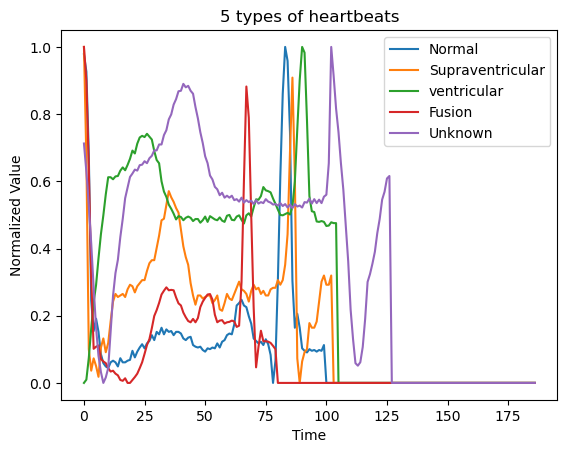

In [393]:
#i is intially 0 
#get one rows that have the 0 label
#plot that thing 

types = {0:"Normal", 1:"Supraventricular", 2:"ventricular", 3:"Fusion", 4:"Unknown"}

for i in range(5):
    sample = train_df[train_df[187] == i].iloc[0, :-1]
    plt.plot(sample, label=f"{types[i]}")

plt.title("5 types of heartbeats")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


We can use Pandas to let us count the frequency of the different classes within the dataset

In [394]:
show_train = train_df.value_counts([187])

pd.DataFrame(show_train)

,count
187,
0.0,72471
4.0,6431
2.0,5788
1.0,2223
3.0,641


In [395]:
show_test = test_df.value_counts([187])
pd.DataFrame(show_test)

,count
187,
0.0,18118
4.0,1608
2.0,1448
1.0,556
3.0,162


Oh oh, we can see quite drastic imbalance between classes. We will need to apply smote

In [396]:
X_train = train_df.drop(columns=[187])
y_train = train_df[187]
X_test =  test_df.drop(columns=[187])
y_test = test_df[187]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(87554, 187)
(87554,)
(21892, 187)
(21892,)


In [397]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)

print(X_train.shape)
print(y_train.shape)

(362355, 187)
(362355,)


In [398]:
#make sure to make them numpy arrays before comverting to tensor
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(362355, 187)
(362355,)
(21892, 187)
(21892,)


In [399]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([362355, 187])
torch.Size([362355])
torch.Size([21892, 187])
torch.Size([21892])


In [400]:
class Multi_NN_ECG(nn.Module):
    def __init__(self, input_size=187, h1=256, h2=128, h3=64, out=5, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, out)

        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(dropout_rate) 
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

In [401]:
multi_nn_model = Multi_NN_ECG()

optimizer = torch.optim.Adam(multi_nn_model.parameters(), lr= 0.001)

loss_func =nn.CrossEntropyLoss() #this is your critereon

torch.manual_seed(42)


In [402]:
multi_nn_model

Multi_NN_ECG(
  (fc1): Linear(in_features=187, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

now, as our datasat is quite large, we need to use a dataloader. as not doing so would make our training take longer

In [403]:
#rom torch.utils.data import DataLoader, TensorDataset

#turn tem into a tensor dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [404]:
#make data loaders
batch_size = 64 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Recall:
- Average = sum of all numbers / total count of numbers
- Accuracy = number of correct predictions / total number of predictions

In this case, out total count of nums and predictions is really just the toal amount of samples we processed, aka the accumulated count of samples during each bach



In [405]:
import time

epochs = 100

#for graphs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

start_time = time.time()
#TRAINING#
for i in range(epochs):
    multi_nn_model.train()
    #for confusion matrix
    train_preds = []
    train_truths = []
    test_preds = []
    test_truths = []

    correct_preds = 0
    accumulated_loss = 0
    total_samples = 0
    #since we are processing data in batches, we need to change the way
    #we calculating accuracy and loss, as we just dont want it for the batches but the while epoch

    for X_batch, y_batch in train_loader:
        y_pred_train = multi_nn_model(X_batch)
        train_loss = loss_func(y_pred_train, y_batch)

        #mutliply the batches loss by its total num of samlpes (64) as the 
        #loss by loss_func (CrossEntropyLoss) is the average loss 
        #per sample in the current batch, not the total loss for the batch.
        accumulated_loss += train_loss.item() * X_batch.size(0)

        #for accuracy
        train_predicted = torch.argmax(y_pred_train, dim=1)
        correct_preds += (train_predicted == y_batch).sum().item()
        total_samples += X_batch.size(0)

        #for confusion matrix
        train_preds.extend(train_predicted.numpy())
        train_truths.extend(y_batch.numpy())

        #backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    #we calculate loss and acuracy this way in order to get said measuremts so tha tthey apply
    #accross all epochs. 
    train_acc = (correct_preds / total_samples) * 100
    avg_train_loss = accumulated_loss / total_samples

    #graphs and stats
    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)

    #TESTTING#
    multi_nn_model.eval()

    #reset these so we can reuse them
    correct_preds = 0
    accumulated_loss = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred_test = multi_nn_model(X_batch)
            test_loss = loss_func(y_pred_test, y_batch)

            accumulated_loss += test_loss.item() * X_batch.size(0)

            #accuracy
            test_predicted = torch.argmax(y_pred_test, dim=1)
            correct_preds += (test_predicted == y_batch).sum().item()
            total_samples += X_batch.size(0)

            #for confusion
            test_preds.extend(test_predicted.numpy())
            test_truths.extend(y_batch.numpy())
            
        test_acc = (correct_preds / total_samples) * 100
        avg_test_loss = accumulated_loss / total_samples

        test_losses.append(avg_test_loss)
        test_accuracies.append(test_acc)
            
    
    print(f"Epoch {i+1} / {epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

current_time = time.time()
total = current_time - start_time
print("")
print(f"this took {total} seconds \n")



Epoch 1 / 100
Train Loss: 0.4299, Train Accuracy: 84.4009
Test Loss: 0.3655, Test Accuracy: 86.4151
Epoch 2 / 100
Train Loss: 0.2708, Train Accuracy: 90.3120
Test Loss: 0.2295, Test Accuracy: 91.5494
Epoch 3 / 100
Train Loss: 0.2350, Train Accuracy: 91.7219
Test Loss: 0.2636, Test Accuracy: 90.2110
Epoch 4 / 100
Train Loss: 0.2141, Train Accuracy: 92.5043
Test Loss: 0.2125, Test Accuracy: 92.3260
Epoch 5 / 100
Train Loss: 0.1987, Train Accuracy: 93.0949
Test Loss: 0.2366, Test Accuracy: 91.6271
Epoch 6 / 100
Train Loss: 0.1881, Train Accuracy: 93.5486
Test Loss: 0.2276, Test Accuracy: 91.7321
Epoch 7 / 100
Train Loss: 0.1791, Train Accuracy: 93.8897
Test Loss: 0.1939, Test Accuracy: 93.3126
Epoch 8 / 100
Train Loss: 0.1708, Train Accuracy: 94.1223
Test Loss: 0.2025, Test Accuracy: 93.2989
Epoch 9 / 100
Train Loss: 0.1669, Train Accuracy: 94.3795
Test Loss: 0.1502, Test Accuracy: 95.1261
Epoch 10 / 100
Train Loss: 0.1635, Train Accuracy: 94.5324
Test Loss: 0.1718, Test Accuracy: 94.3039

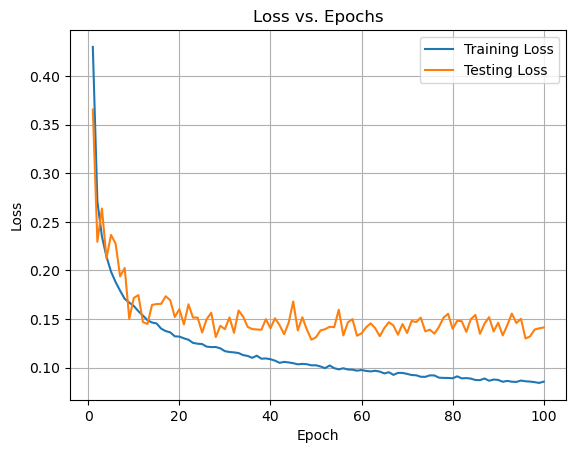

In [406]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), test_losses, label="Testing Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

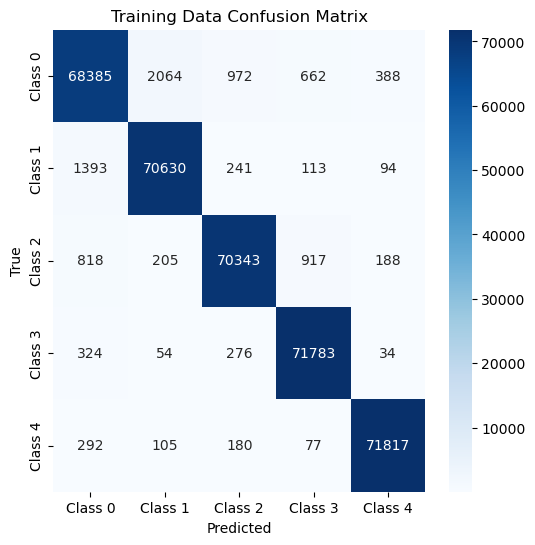

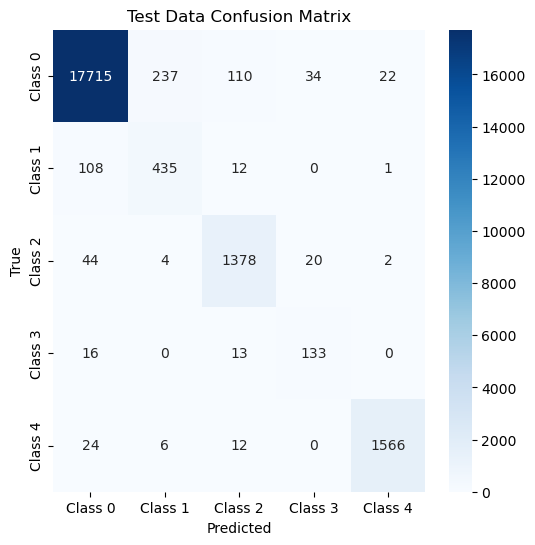

In [407]:
#confusion matrix for training data
train_cm = confusion_matrix(train_truths, train_preds)

#plot confusion matrix for training data
plt.figure(figsize=(6, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#calculate confusion matrix for test data
test_cm = confusion_matrix(test_truths, test_preds)

#plot confusion matrix for test data
plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
